# Moving Average Time Series
First we start with some basic imports and set some defaults. For the most part we use the classes defined under endochrone/arima for fitting these models. Statsmodels provides a useful API for generating data. As this notebook is intended to showcase the Endochrone Algorithms, we won't use statsmodels for making predictions.

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_process import arma_generate_sample

import sys; sys.path.insert(0, '..')
from endochrone.stats.correlation import acf, pacf
from endochrone.time_series.arima import ArModel, MaModel

plt.rc('figure', figsize=(20.0, 10.0))

### MA1
First we generate some well-behaved data which we can use to for modelling. We define a partial function purely for convenience as we'll want to generate more data for testing according to the same paramaters

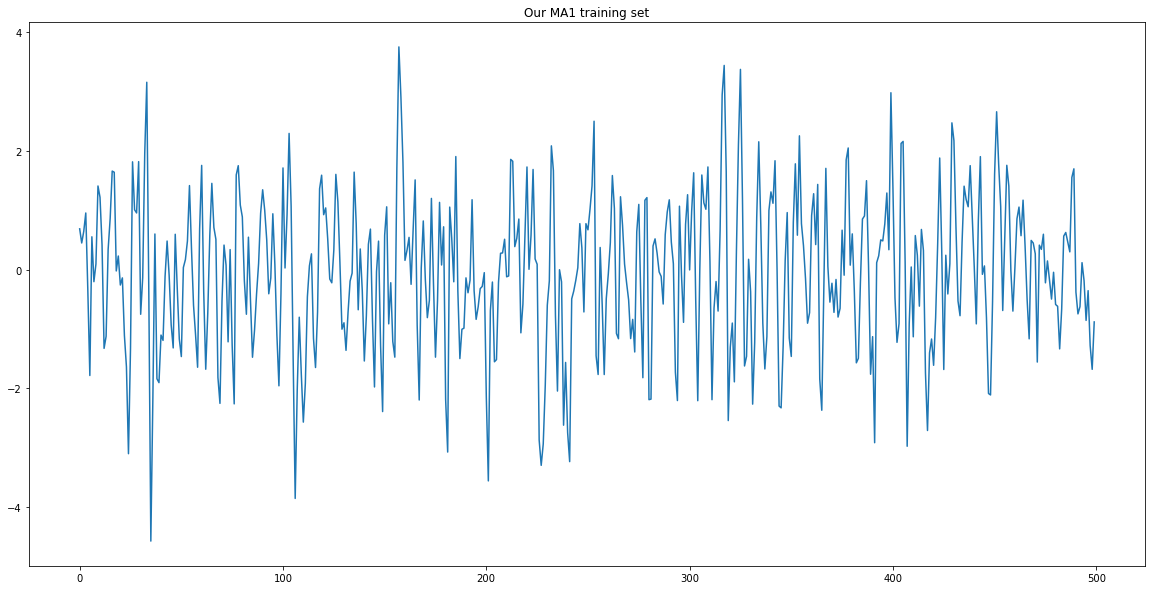

In [2]:
np.random.seed(seed=1235)
ma1_func = partial(arma_generate_sample, [1], [1, 0.7], scale=1)
N_train = 500
x = ma1_func(N_train)
plt.title("Our MA1 training set")
plt.plot(range(N_train), x);

First we look at our ACF and PACF for patterns

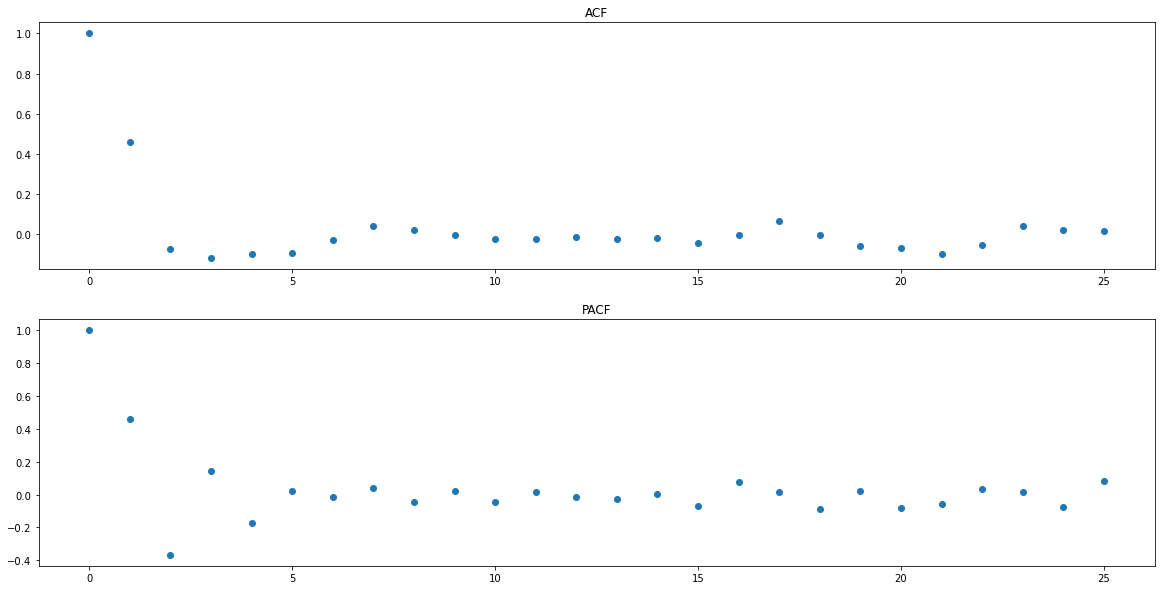

In [3]:
n_lags = 25
ar1_acf = acf(x, lags=n_lags).values
ar1_pacf = pacf(x, lags=n_lags).values
fig1, a1 = plt.subplots(2,1)
a1[0].scatter(range(n_lags+1), ar1_acf)
a1[0].set_title('ACF')
a1[1].scatter(range(n_lags+1), ar1_pacf)
a1[1].set_title('PACF');

There is a slight (but significant) correlation in the 1-lag ACF which quickly decays to zero for subsequent lags. This suggests an MA1 model. We already knew this as we generated the data!

In [4]:
ma1 = MaModel(order=1)
ma1.fit(x)

print(ma1.thetas_)

[-0.06288718  0.7015152 ]


Which is pretty close to what we expect. Our intercept to be around zero, and the coefficient to be 0.7 as this is what we put in our signal generator. We should check our model correcly accounts for all available correlation though. We can do this by inspecting the residuals which we'd expect to be indistinguishable from noise

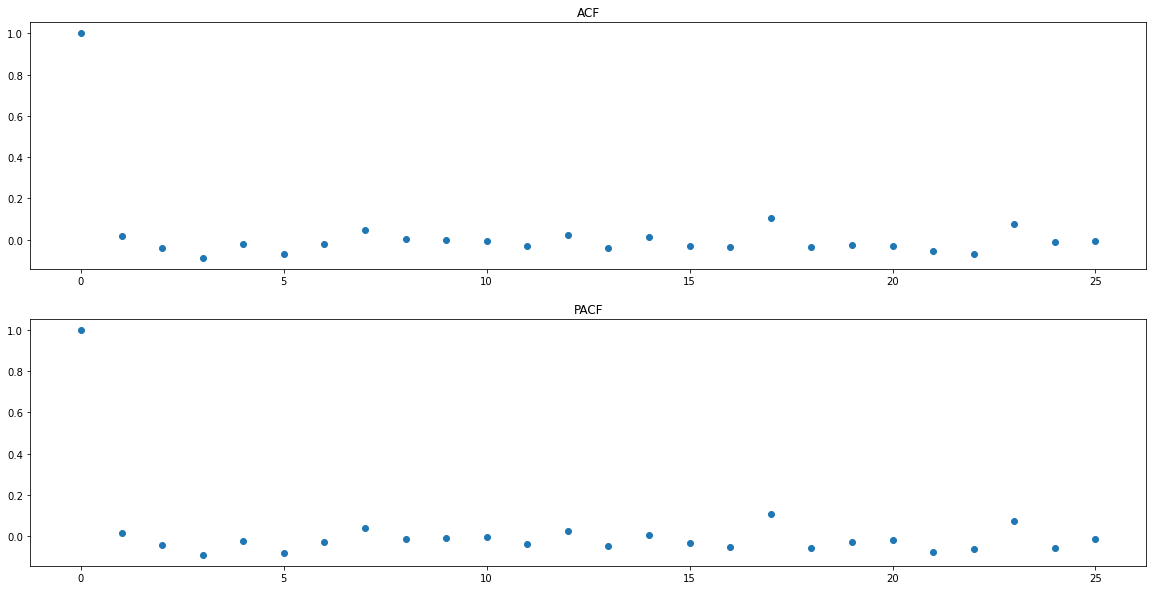

In [5]:
ma1_res = ma1.residuals_
n_lags = 25
ma1_res_acfs = acf(ma1_res, lags=n_lags).values
ma1_res_pacfs = pacf(ma1_res, lags=n_lags).values
fig, a = plt.subplots(2,1)
a[0].scatter(range(n_lags+1), ma1_res_acfs)
a[0].set_title('ACF')
a[1].scatter(range(n_lags+1), ma1_res_pacfs)
a[1].set_title('PACF');

Mean Sq Error: 1.082492352361549
Mean of residuals: -0.0018448912073902193
Variance of residuals: 1.082488948737982


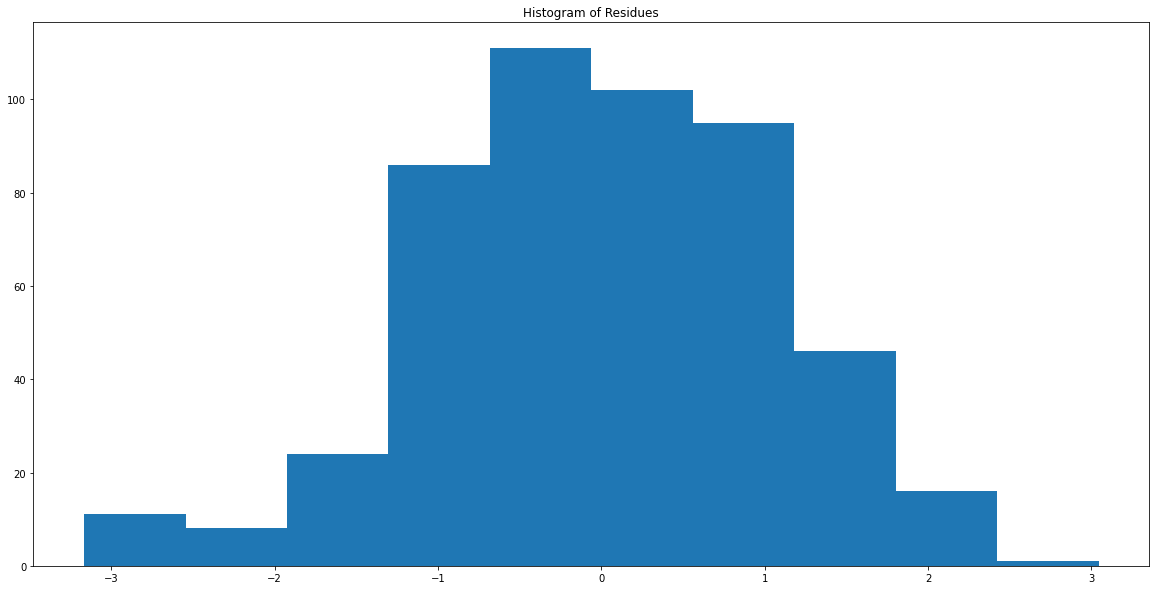

In [6]:
print('Mean Sq Error:', np.mean(ma1_res**2))
print('Mean of residuals:', np.mean(ma1_res))
print('Variance of residuals:', np.var(ma1_res))
plt.title('Histogram of Residues');
plt.hist(ma1_res, bins=10);

Looks pretty normal to me! 

Now lets see how we do against some new data generated according to the same profile. (NB. We do this stepwise - we aren't predicting 30 steps out, we predict each step by looking at the previous correct answer.)

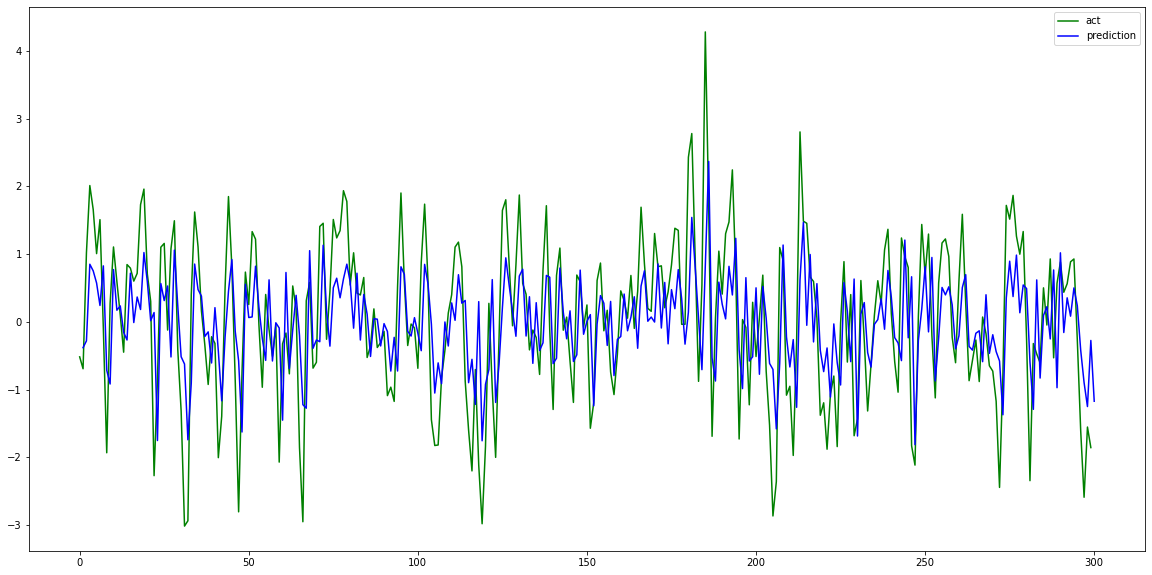

In [7]:
N_test = 300
y = ma1_func(N_test)
y_pred = ma1.predict(y)

plt.plot(range(N_test), y, c='green', label='act')
plt.plot(range(1, N_test+1), y_pred, c='blue', label='prediction')
plt.legend();

In [8]:
ma1_errs = y[1:] - y_pred[:-1]
print('Mean Sq Error:', np.mean(ma1_errs**2))
print('Mean Error:', np.mean(ma1_errs))
print('Var Error:', np.var(ma1_errs))

Mean Sq Error: 0.8920431479461093
Mean Error: 0.06365962989999294
Var Error: 0.887990599467105


### MA7
Let's try a slightly more complex model. This time we'll add values for the 7th term to simulate a weekly cycle. (NB I initially tried this with a 28 day term too, but both the endochrone and statsmodel were much too slow to fit to be of practical use)

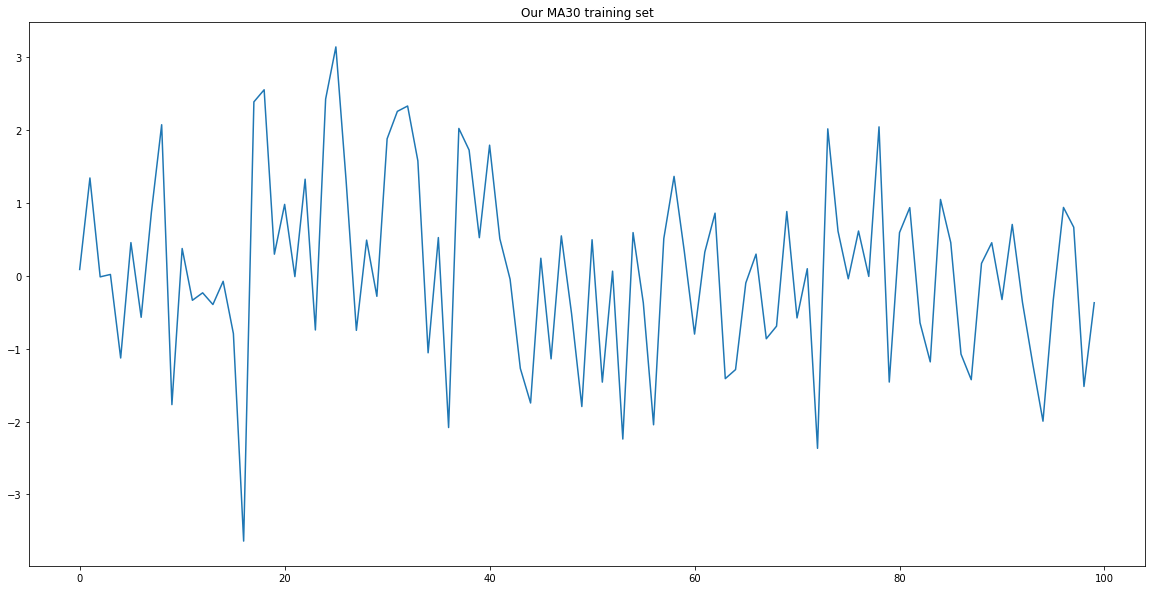

In [35]:
np.random.seed(seed=14545)
corrs = [1, 0.25] + 5*[0] + [0.84]
ma2_func = partial(arma_generate_sample, [1], corrs, scale=1)
N_train = 5000
x2 = ma2_func(N_train)
plt.title("Our MA7 training set")
plt.plot(range(100), x2[:100]);

You can see the cycling as we know it's there, but the ACF and PACF should make it much clearer

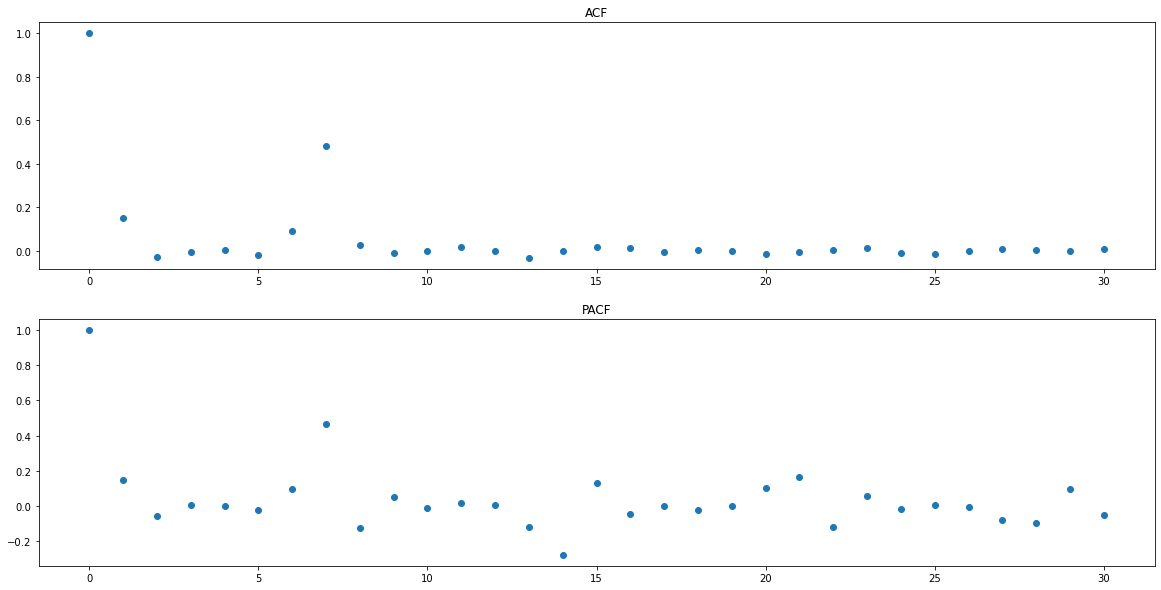

In [36]:
n_lags = 30
ma2_acf = acf(x2, lags=n_lags).values
ma2_pacf = pacf(x2, lags=n_lags).values
fig2, a2 = plt.subplots(2,1)
fig2.size=(6,4)
a2[0].scatter(range(n_lags+1), ma2_acf)
a2[0].set_title('ACF')
a2[1].scatter(range(n_lags+1), ma2_pacf)
a2[1].set_title('PACF');

Indeed we see cycles on a weekly basis. Let's fit our model. We'll plot our coefficients as it's easier to see which ones are far from zero. It's a little slow...

In [50]:
ma2 = MaModel(order=7)
ma2.fit(x2)

True

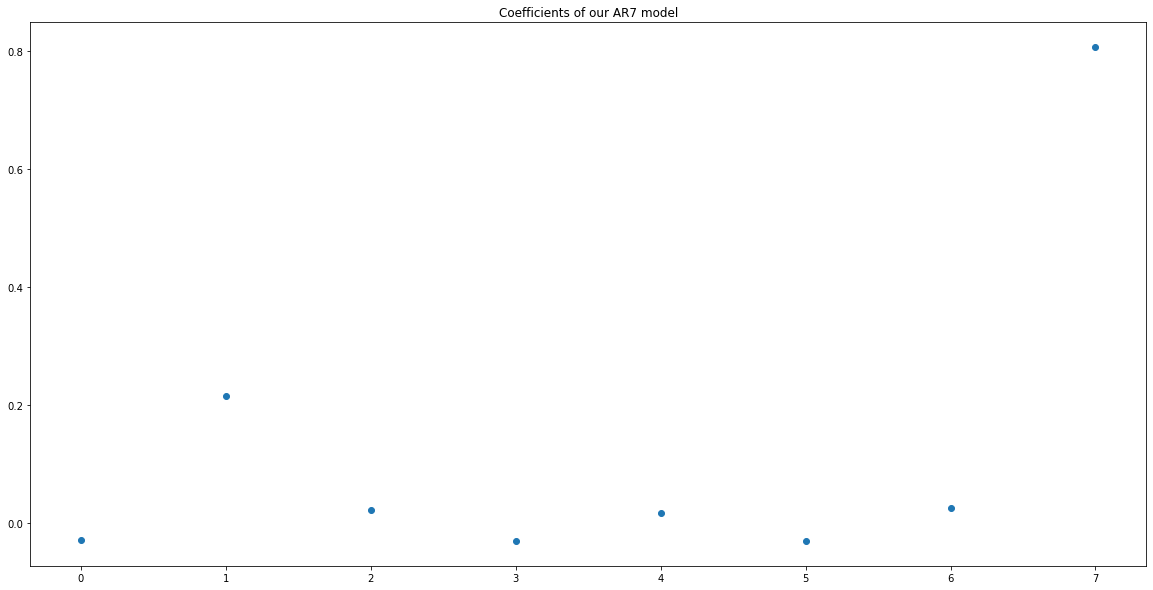

In [51]:
plt.scatter(range(0,8), ma2.thetas_);
plt.title("Coefficients of our MA7 model");

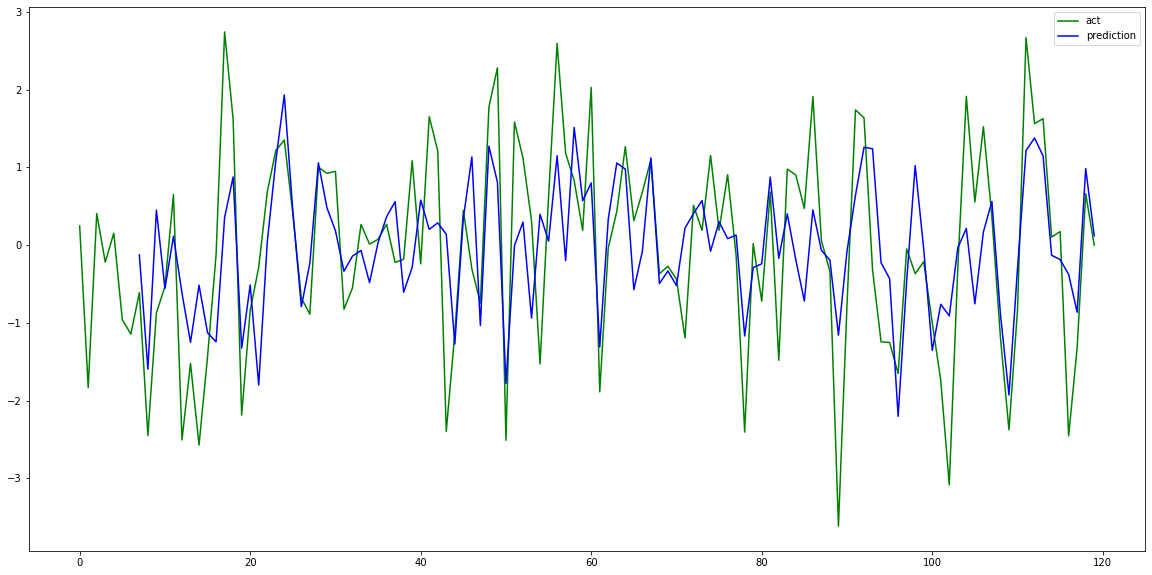

In [53]:
N_test = 300
y2 = ma2_func(N_test)
y2_pred = ma2.predict(y2)

x2_pred = ma2.predict(x2)

plt.plot(range(0, 120), y2[0:120], c='green', label='act')
plt.plot(range(7, 120), y2_pred[:113], c='blue', label='prediction')
plt.legend();

Though we predicted 271 steps, only 60 are shown in the graph. If we plot more than that and it's a little hard to see the cycling. You can see a broad repeating pattern of peaks every 7 days. Though I'll admit visually the fit doesn't seem that good

Let's finally compare our errors:

In [55]:
print('MSE(Training): %06f' % np.mean(ma2.residuals_**2))
ma2_errs = y2[7:] - y2_pred[:-7]
print('MSE(Forecast): %06f' % np.mean(ma2_errs**2))

MSE(Training): 0.984365
MSE(Forecast): 0.954835


This is about what we'd expect as it's the variance of our white noise. As these values are similar it suggests we've avoided over/under-fitting. I'm not completely satisfied with the fit here, so lets quickly compare to the statsmodels implementation.

In [41]:
from statsmodels.tsa.arima_model import ARMA

In [62]:
sm_ma2 = ARMA(x2, order=(0,7))
sm_fit_results = sm_ma2.fit()

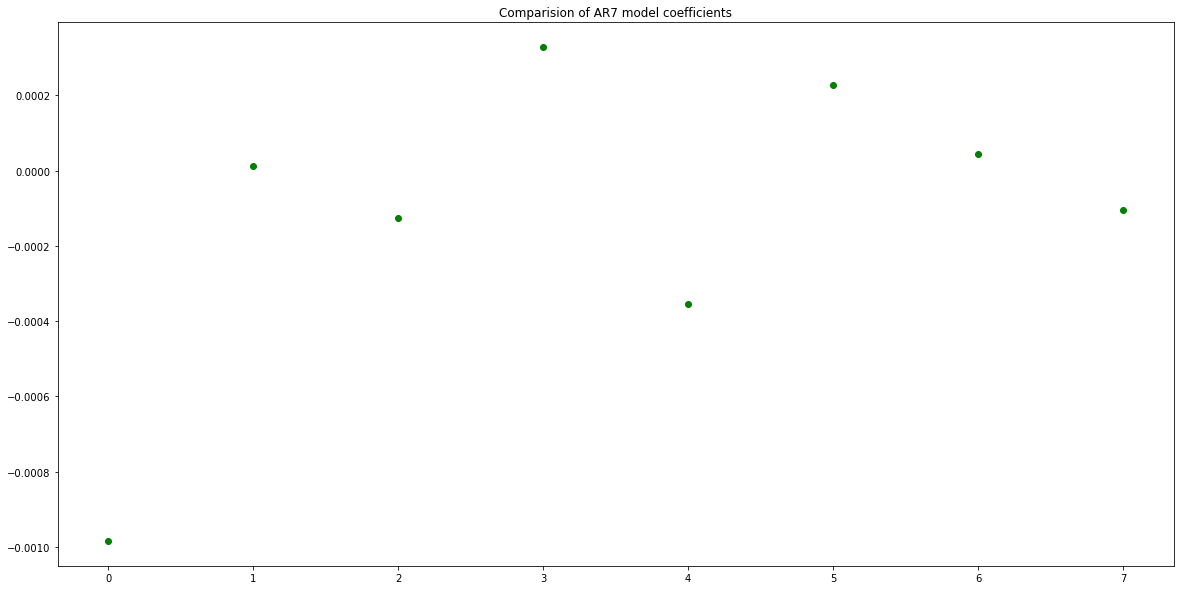

In [63]:
plt.scatter(range(0,8), ma2.thetas_ - sm_fit_results.params, c='green', label='Difference between Models');
plt.title("Comparision of MA7 model coefficients");

The differences here are small enough that we can call the two models equivalent